In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_fake_image(shape, noise_level=0.1):
    """
    Generate a fake image with a noisy 2D Gaussian source.

    Parameters:
    - shape: Tuple (M, N) representing the dimensions of the image.
    - noise_level: The standard deviation of the Gaussian noise.

    Returns:
    - A 2D NumPy array representing the fake image.
    """

    M, N = shape

    # Generate a grid of x and y coordinates
    x = np.arange(N)
    y = np.arange(M)
    xx, yy = np.meshgrid(x, y)

    # Randomize Gaussian parameters
    amplitude = np.random.uniform(0.5, 1.5)
    xo = np.random.uniform(1/4*N, 3/4*N)
    yo = np.random.uniform(1/4*M, 3/4*M)
    #sigma_x = np.random.uniform(1, 5)
    #sigma_y = np.random.uniform(1, 5)
    sigma_x = 3 # fixed size for map making
    sigma_y = 3
    theta = np.random.uniform(0, np.pi)
    offset = np.random.uniform(0, 0.1)

    # Calculate 2D Gaussian
    gaussian_source = (
        amplitude * np.exp(
            -((xx - xo) ** 2) / (2 * sigma_x ** 2) - ((yy - yo) ** 2) / (2 * sigma_y ** 2)
        )
    )

    # Add Gaussian noise
    noisy_image = gaussian_source + noise_level * np.random.normal(size=(M, N))
    return noisy_image

def generate_fake_images(num_images):
    image_shape = (50, 50)
    fake_images = [generate_fake_image(image_shape) for n in range(num_images)]
    #fake_image = generate_fake_image(image_shape)

    # Visualize the fake images
    fig, axes = plt.subplots(1, len(fake_images), figsize=(15, 5))
    for i, im in enumerate(fake_images):
        axes[i].imshow(im, cmap='viridis')
        axes[i].set_title(f'fake Image {i}')

    return fake_images

In [4]:
def find_brightest_pixel(image):
    # Find the indices of the maximum value in the 2D array
    indices = np.unravel_index(np.argmax(image, axis=None), image.shape)
    return indices

In [5]:
from scipy.optimize import curve_fit
from scipy.ndimage import shift
from scipy.ndimage import gaussian_filter

def gaussian_2d(xy, amplitude, yo, xo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude * np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(image):
    # Get image dimensions
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    
    # Initial guess for the parameters
    #initial_guess = (np.max(image), np.argmax(image) % image.shape[1], np.argmax(image) // image.shape[1], 2., 2., 0.0, np.min(image))
    initial_guess = (np.max(image), *np.unravel_index(image.argmax(), image.shape), 
                     2., 2., 0.0, np.min(image))

    # Fit the 2D Gaussian
    popt, pcov = curve_fit(gaussian_2d, (x, y), image.ravel(), p0=initial_guess)

    # Extract the center coordinates from the fitted parameters
    center_x, center_y = popt[1], popt[2]

    return center_x, center_y

In [6]:
from scipy.ndimage import shift

def align_images(images, fit_func):
    # Find the brightest pixel in the reference image
    reference_image = images[0]
    #brightest_pixel_ref = find_brightest_pixel(reference_image)
    #reference_center = fit_gaussian(reference_image)
    reference_center = fit_func(reference_image)

    # Initialize a list to store aligned images
    aligned_images = [reference_image]

    # Iterate through the rest of the images and align them
    for i in range(1, len(images)):
        current_image = images[i]

        # Find the brightest pixel in the current image
        current_center = fit_func(current_image)

        # Calculate the shift needed to align the current image with the reference image
        shift_amount = np.array(reference_center) - np.array(current_center)

        # Shift the current image
        aligned_image = shift(current_image, shift_amount)

        # Append the aligned image to the list
        aligned_images.append(aligned_image)

    return aligned_images

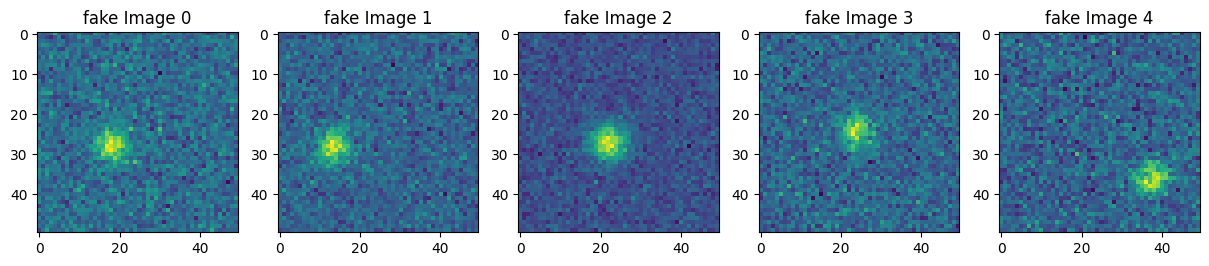

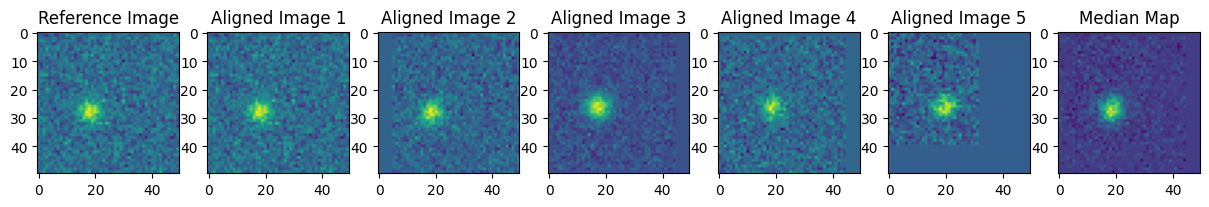

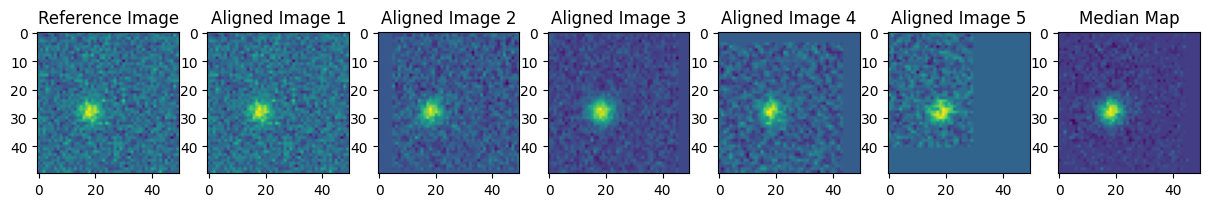

In [10]:
def multiDetectorMap_BrightestPixel():
    # Example usage:
    # images is a list of 2D NumPy arrays representing the astronomical images
    # Make sure all images have the same shape

    # Assuming you have a list of images like this:
    # images = [image1, image2, image3, ...]
    images = generate_fake_images(num_images=5)

    def plotMaps(images, aligned_images):
        fig, axes = plt.subplots(1, len(aligned_images) + 2, figsize=(15, 5))
        axes[0].imshow(images[0], cmap='viridis')
        axes[0].set_title('Reference Image')
        for i, aligned_image in enumerate(aligned_images):
            axes[i+1].imshow(aligned_image, cmap='viridis')
            axes[i+1].set_title(f'Aligned Image {i+1}')
        axes[len(aligned_images) + 1].imshow(map_med, cmap='viridis')
        axes[len(aligned_images) + 1].set_title('Median Map')
        plt.show()
    
    # Align the images by brightest pixel and take median map
    aligned_images = align_images(images, find_brightest_pixel)
    map_med = np.median(aligned_images, axis=0)
    plotMaps(images, aligned_images)

    # Align the images with 2d gaussian and take median map
    aligned_images = align_images(images, fit_gaussian)
    map_med = np.median(aligned_images, axis=0)
    plotMaps(images, aligned_images)
    
multiDetectorMap_BrightestPixel()

In [8]:
p = np.array([[0.1,3],[0,np.nan]])

In [9]:
find_brightest_pixel(p)

(1, 1)